In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
%matplotlib inline

In [2]:
data = pd.read_csv("datacollection_tpmc.log", sep="\t")
data

innodb_pool_size   wearhouse   disk_quota   cpu_quota      tpmc  \
0                    1          10            1      100000  5216.210   
1                    1          10            1      250000  5064.316   
2                    1          10            1      500000  4605.158   
3                    1          10            1     1000000  2395.895   
4                    1          10            2      100000  2555.368   
...                ...         ...          ...         ...       ...   
1227              1024          64           32     1000000  3265.263   
1228              1024          64           48      100000  5032.105   
1229              1024          64           48      250000  4908.316   
1230              1024          64           48      500000  5089.263   
1231              1024          64           48     1000000  5095.263   

      mid_99%  mid_95%  mid_rt_max  
0      97.533  117.845     148.531  
1     119.765  147.772     192.415  
2     178.333  218.395     269.688  
3     602.848  681.771     754.964  
4     213.803  400.882     584.301  
...       ...      ...         ...  
1227  379.058  523.260     623.056  
1228  185.354  323.448     601.402  
1229  271.165  398.847     564.287  
1230  320.557  523.573     812.014  
1231  372.199  696.416    1012.417  

[1232 rows x 8 columns]

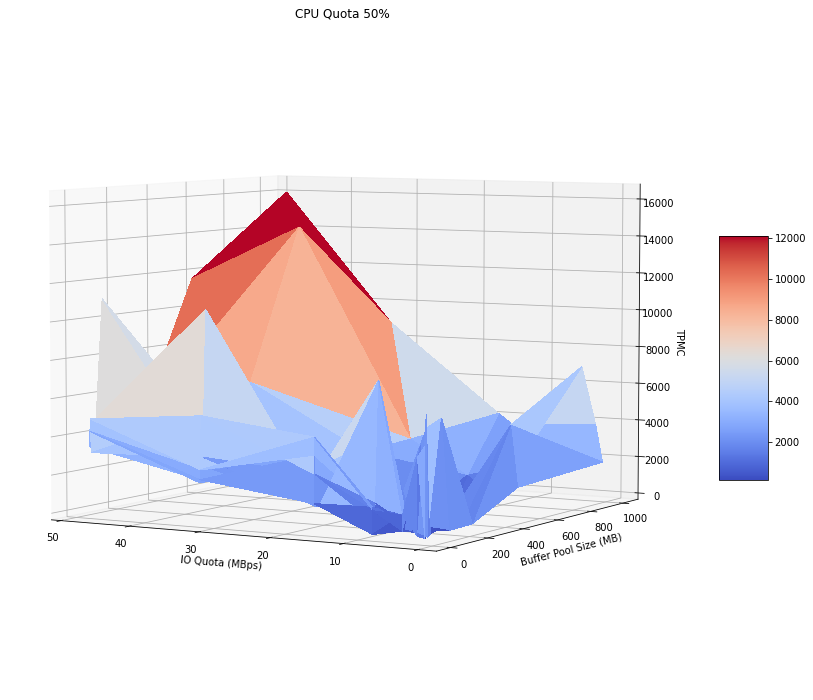

In [3]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
surf = ax.plot_trisurf(data[data[' cpu_quota']==500000][' disk_quota'], 
                data[data[' cpu_quota']==500000]['innodb_pool_size'], 
                data[data[' cpu_quota']==500000][' tpmc'], linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax.set_title('CPU Quota 50%')
ax.set_xlabel('IO Quota (MBps)', fontsize=10)
ax.set_ylabel('Buffer Pool Size (MB)', fontsize=10)
ax.set_zlabel('TPMC', fontsize=10, rotation=270)
ax.invert_xaxis()
fig.colorbar(surf, shrink=0.3, aspect=5)
ax.view_init(elev=5, azim=-60)
plt.savefig("cpu_quota_50.png")

/tmp/ipykernel_7570/2470044667.py:12: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(surf, shrink=0.3, aspect=5)


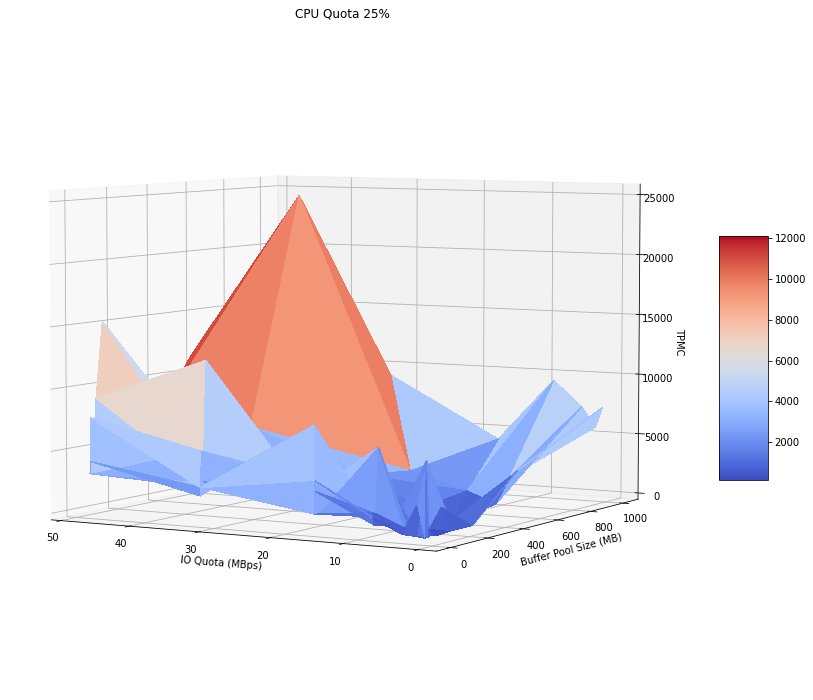

In [4]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.plot_trisurf(data[data[' cpu_quota']==250000][' disk_quota'], 
                data[data[' cpu_quota']==250000]['innodb_pool_size'], 
                data[data[' cpu_quota']==250000][' tpmc'], linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax.set_title('CPU Quota 25%')
ax.set_xlabel('IO Quota (MBps)', fontsize=10)
ax.set_ylabel('Buffer Pool Size (MB)', fontsize=10)
ax.set_zlabel('TPMC', fontsize=10, rotation=270)
ax.view_init(elev=5, azim=-60)
ax.invert_xaxis()
fig.colorbar(surf, shrink=0.3, aspect=5)
plt.savefig("cpu_quota_25.png")

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

In [6]:
def rfr_model(X, y, model):
    print(model)
    # Perform Grid-Search
    if 'RandomForestRegressor' in str(model):
        gsc = GridSearchCV(
            estimator=model(),
            param_grid={
                'max_depth': range(3,7),
                'n_estimators': (10, 50, 100, 500),
            },
            cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

        grid_result = gsc.fit(X, y)
        best_params = grid_result.best_params_

        model = model(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=False, verbose=False)
    else:
        model = model(random_state=False, verbose=False)
    # Perform K-Fold CV
    scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')
    return scores, model

In [7]:
scaler = MinMaxScaler()
scaler.fit(data)
data = scaler.transform(data)

In [8]:
x, y = data[:,:-1], data[:,-1]

In [9]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.10)
print(f"Train samples : {train_x.shape[0]} Test samples : {test_x.shape[0]}")

Train samples : 1108 Test samples : 124


In [10]:
scores, model = rfr_model(train_x, train_y, RandomForestRegressor)
print(f"Best model : {model}")
print(f"Average mean sqaured error : {-scores.mean()}")

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best model : RandomForestRegressor(max_depth=4, n_estimators=50, random_state=False,
                      verbose=False)
Average mean sqaured error : 0.0006073483219726087


In [11]:
scores, model = rfr_model(train_x, train_y, LinearSVR)
print(f"Best model : {model}")
print(f"Average mean sqaured error : {-scores.mean()}")

<class 'sklearn.svm._classes.LinearSVR'>


/home/devesh/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/devesh/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/devesh/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/devesh/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/devesh/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/devesh/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to 

Best model : LinearSVR(random_state=False, verbose=False)
Average mean sqaured error : 0.0004154532025503371


/home/devesh/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/devesh/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/devesh/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/devesh/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
